In [1]:
import sys
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import math 
from gensim.models import Word2Vec
import re
import pickle

In [2]:
plt.figure(figsize=(20,10))
style.use('seaborn-poster')
sns.set() #reset seaborn style


<Figure size 1440x720 with 0 Axes>

In [3]:
df = pd.read_pickle('Data/clean_data')
df['matchingCVV'] = df['cardCVV'] == df['enteredCVV']
df['matchingCountry'] = df['acqCountry'] == df['merchantCountryCode']

## Process binary feature columns into 0,1
for col in ['cardPresent', 'matchingCVV','matchingCountry', 'expirationDateKeyInMatch', 'isFraud']:
    df[col] = df[col].replace({False: 0, True: 1})

In [4]:
df=df.sort_values(by=['customerId','transactionDateTime'], ascending = True).reset_index(drop=True)

## Parse DateTime

The purpose of this part is to parse 'transactionDateTime' column, generating a datetime type column for future computation, and convert this datetime feature into categorical data of year, month, day, and polar coordinate data of hour and minutes. In particular, we use polar coordinate to represent hours and minutes in to better represent the continuity of time. 

In [5]:
def parse_datetime(date_str):
    line = date_str.split('T')
    date = line[0].split('-')
    time = line[1].split(':')
    stamp = datetime(int(date[0]), int(date[1]),  int(date[2]), int(time[0]), int(time[1]), int(time[2]))
    
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    
    PI = math.pi
    hour_cos = math.cos(2*PI*int(time[0])/24)
    hour_sin = math.sin(2*PI*int(time[0])/24)
    min_cos = math.cos(2*PI*int(time[1])/60)
    min_sin = math.sin(2*PI*int(time[1])/60)
    return stamp, year, month, day, hour_cos, hour_sin, min_cos, min_sin

In [6]:
df['transactionDateTimeStamp'], df['year'], df['month'], df['day'], \
df['hour_cos'], df['hour_sin'], df['min_cos'], df['min_sin'] = \
zip(*df['transactionDateTime'].apply(parse_datetime))

## Reversed transactions

It is just straitforward to find the reversal reversed transactions. However, I would like to try build a method to find the purchase followed by a reversal.

In [7]:
num_rev = df.loc[df['transactionType' ]== 'REVERSAL'].shape[0]
amount_rev = df.loc[df['transactionType' ]== 'REVERSAL', 'transactionAmount'].sum()
print('number of reversal transactions: {}'.format(num_rev))
print('Dollar amount of reversal transactions: {}'.format(round(amount_rev,4)))

indice_rev =  df.loc[df['transactionType' ]== 'REVERSAL'].index

number of reversal transactions: 20303
Dollar amount of reversal transactions: 2821792.5


In [8]:
def get_reversed_index(df):
    res = list()
       
    df_rev = df[['accountNumber', 'transactionAmount', 'merchantName']]
    df_rev = df_rev[df_rev.duplicated(keep=False)]
    df_rev = df_rev.groupby(df_rev.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()
    
    for group in df_rev:
        for i in range(len(group)-1, -1, -1):
            if df.loc[group[i],'transactionType']  == 'REVERSAL':
                for j in range(i-1, -1, -1):
                    if df.loc[group[j],'transactionType']  == 'PURCHASE':
                        res.append(group[j])
                        break
    return res

In [9]:
reversed_index = get_reversed_index(df)
print(len(reversed_index))

17759


In [10]:
df['isReverse'] = 0
df.loc[indice_rev,'isReverse'] = 1
df.loc[reversed_index,'isReverse'] = 2

In [11]:
reversed_amount = df.loc[df['isReverse' ]== 2, 'transactionAmount'].sum()
print('Number of reversed transactions (pairs): {}'.format(len(reversed_index)))
print('Dollar amount of reversed transactions: {}'.format(round(reversed_amount,4)))

Number of reversed transactions (pairs): 17759
Dollar amount of reversed transactions: 2666519.27


- Number of reversed transactions (pairs): 17759
- Dollar amount of reversed transactions: 2675432.46


In [12]:
df_rev = df.loc[df['transactionType']== 'REVERSAL']
df_rev.accountNumber.value_counts()[:20]

380680241    907
882815134    384
570884863    300
246251253    277
369308035    211
894938833    181
832842201    177
724518977    173
419709514    171
208319653    148
410523603    140
442799740    131
767620004    126
409705516    112
225678947    109
269616174    107
474934734    105
682319827    103
379443741     99
132629755     95
Name: accountNumber, dtype: int64

In [13]:
df['isReverse'].corr(df['isFraud'])

0.0018849642772337425

#### Other Findings

- Some revesals cannot find a corresponding purchase in the dataset
- A small group of users have abnormal number of reversed transcations
- The reversal does not appear to correlate with fraud action

## Multi-swipe transactions

### Find multi-swipe transactions, method one

This is a naive way to find multi-swipe transactions. I use the built-in diff method to get potential indices, instead of going through the whole dataframe. It is more robust since it can guarantee the close multi-swipe transactions given your choice of time interval. However, it can becoming even slower when the data size getting large, and may miss some extreme cases if there are other transactions between multi-swipe transactions.



#### If we stick to this method, we assume that only adjacent transactions can be multi-swipe transactions

In [14]:
## First use the built-in diff method to get potential indices
diff = df.transactionAmount.diff()
indices = [ind for ind, val in diff.iteritems() if val ==0.00]
print(len(indices))

20758


In [15]:
mult_index_0 = list()
time_interval = 600
for i in indices:
    if df.loc[i,'transactionType']  == 'PURCHASE' and df.loc[i,'transactionAmount'] == df.loc[i-1,'transactionAmount'] and df.loc[i,'merchantName'] == df.loc[i-1,'merchantName']:
            delta = df.loc[i,'transactionDateTimeStamp'] - df.loc[i-1,'transactionDateTimeStamp']
            if delta.seconds < time_interval:
                mult_index_0.append(i)

In [16]:
print('number of multi-swipe transactions (except the first one): {}'.format(len(mult_index_0)))

number of multi-swipe transactions (except the first one): 7417


### Find multi-swipe transactions, method two

The follwing method to find the indices of multi-swipe transactions multi-swipe transactions works in the similar speed as the method above. However, it can capture the case where some transactions are between two multi-swipe transactions without using complex nested loops. 

#### I will relax the assumption that only adjacent transactions can be multi-swipe transactions. However, there is an extra assumption here that the matchingCVV should be the same and be successful. Otherwise it might be just re-trys rather than multi-swipe transactions.

In [17]:
def get_multi_swipe(df):
    mult_index = list()

    df_mul = df.loc[(df['matchingCVV' ]== 1) & (df['transactionType']  == 'PURCHASE')][['accountNumber', 'transactionAmount', 'merchantName', 'matchingCVV']]
    df_mul = df_mul[df_mul.duplicated(keep=False)]
    df_mul = df_mul.groupby(df_mul.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()

    time_interval = 600

    for group in df_mul:
        for i in range(1, len(group)):
            delta = df.loc[group[i],'transactionDateTimeStamp'] - df.loc[group[i-1],'transactionDateTimeStamp']
            if delta.seconds < time_interval:

                mult_index.append(group[i])
    return mult_index

In [18]:
df['isMultiple'] = 0
mult_index_1 = get_multi_swipe(df)
print('number of multi-swipe transactions (except the first one): {}'.format(len(mult_index_1)))
df.loc[mult_index_1,'isMultiple'] = 1

number of multi-swipe transactions (except the first one): 7695


In [19]:
swip_amount = df.loc[df['isMultiple' ]== 1, 'transactionAmount'].sum()
print('Dollar amount of multi-swipe transactions: {}'.format(round(swip_amount,4)))

Dollar amount of multi-swipe transactions: 1097638.23


In [20]:
df_multi = df.loc[df['isMultiple']== 1]
df_multi.accountNumber.value_counts()[:20]

380680241    348
882815134    135
570884863    115
369308035     89
246251253     83
894938833     65
419709514     63
724518977     60
410523603     56
208319653     54
767620004     53
474934734     48
700725639     48
442799740     45
832842201     45
325587097     41
307632490     40
225678947     39
379443741     38
269616174     35
Name: accountNumber, dtype: int64

In [21]:
df['isMultiple'].corr(df['isFraud'])

0.00036194696931470286

#### Other Findings

- A small group of users have high number of multi-swipe transcations
- Multi-swipe transcation does not appear to correlate with fraud action

## Feature Construction

### currentExpDate, accountOpenDate, dateOfLastAddressChange
Output feature: 
- expDateDelta: time difference between currentExpDate and transaction date
- openDateDelta: time difference between accountOpenDate and transaction date
- addressDateDelta: time difference between dateOfLastAddressChange and transaction date

The intent of this part is to process some date features. The absolute time of those dates does not really matter. It is the difference (time delta) with the current transcation time that makes more sense. In addition, since we have the transcation time as our data, it is enough to just use the time delta of these three features.

In [22]:
def parse_exp_date(date_str):
    line = date_str.split('/')
    stamp = datetime(int(line[1]), int(line[0]), 1)
    return stamp

In [23]:
df['expDateDelta'] = df.apply(lambda x: (parse_exp_date(x['currentExpDate']) - x['transactionDateTimeStamp']).days, axis =1)

In [24]:
def parse_other_date(date_str):
    line = date_str.split('-')
    stamp = datetime(int(line[0]), int(line[1]), int(line[2]))
    return stamp

In [25]:
df['openDateDelta'] = df.apply(lambda x: (x['transactionDateTimeStamp'] - parse_other_date(x['accountOpenDate'])).days, axis =1)
df['addressDateDelta'] = df.apply(lambda x: (x['transactionDateTimeStamp'] - parse_other_date(x['dateOfLastAddressChange'])).days, axis =1)

### ID Data: accountNumber & customerId
Output feature: 
- id_vec: 10-d w2v embedding vector that represent the accountNumber/customerId


I would like to keep customerId as a feature without worring about the dimensionality. So in this part I introduce the embedding. 

In [26]:
df['matchingID'] = df['accountNumber'] == df['customerId']
df['matchingID'].value_counts()

True    786363
Name: matchingID, dtype: int64

matchingID is just accountNumber. We will use one of them

#### Ideas behind the following embedding construction


In the following part, I constructed embedding features to represent the 'accountNumber' by applying Word2Vec on the sequence of merchants of each account. 

This embedding operation intends to use low-dimensional dense features to represent the highly sparse 'accountNumber' feature. There are 5000 different accounts, and it means the dimension of this feature is at least 5000, which will grow even larger as the sample size increases. It is unacceptable to one-hot encoding this feature for most of the models. 

Therefore, I use the w2v embedding to project the merchants' sequence associated with each account to a  10-dimension vector, which represents a particular account. This idea of item embedding technique has been widely applied in some scenarios, such as recommendation or online shopping. Even though the sequence of merchants' names is not as informative as newsID or itemID, it does capture some information of accountNumber, and I do observe the improvement of the score after adding these embedding features. 

In [27]:
# Join the merchantName and group by on accountNumber. 
# It will ceate a merchant_trace containing names of all merchants in time sequence
merchant_df=df.groupby('accountNumber').apply(lambda x:" ".join(x['merchantName'].astype(str))).rename('merchant_trace').reset_index()
print(merchant_df.head())

   accountNumber                                     merchant_trace
0      100088067  EZ Putt Putt #982199 Dinosaur Sandwitch Bar #3...
1      100108752  Shell Gas #494785 Shell Gas #494785 Shell Gas ...
2      100328049  Quizno's #808797 KFC #113520 Wendys #283022 Ly...
3      100663626  Popeyes #298507 Wendys #254264 Wendys #933486 ...
4      100737756  1st Sandwitch Bar #396252 Downtown Pub Franks ...


In [28]:
def generate_wv_model(df, col, dim):
    df = df.copy()
    line = df[col].values
    sentences = []
    # remove special characters
    stop = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
    for doc in line:
        doc = re.sub(stop, '', doc)
        sentences.append(doc.split())

    # train the w2v to represent merchats
    model = Word2Vec(sentences, size=dim, window=1, min_count=1, workers=4, sg=1)
    return model

In [29]:
def get_vector(model, doc, dim):
    wv = np.zeros(dim)
    counter = 0
    stop = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'

    s = re.sub(stop, '', doc).split()
    for w in s:
        wv += model.wv[w]
        counter += 1
    return wv/counter

First, regard the merchant_trace as a long string and learn the words using w2v. Then fit each word in merchant_trace and take the average.  

In [30]:
w2v=[]
model = generate_wv_model(merchant_df, 'merchant_trace', 10)
for account, trace in zip(merchant_df.accountNumber.values, merchant_df.merchant_trace.values):
    try:
        a = [int(account)]
        a.extend(get_vector(model, str(trace), 10))
        w2v.append(a)   #w2v save the accountNumber and vectors
    except:
        pass

In [31]:
vec_df = pd.DataFrame(w2v)   #create a dataframe
vec_df.columns = ['accountNumber'] + ['id_vec'+str(i) for i in range(10)]
vec_df.head()

,accountNumber,id_vec0,id_vec1,id_vec2,id_vec3,id_vec4,id_vec5,id_vec6,id_vec7,id_vec8,id_vec9
0,100088067,0.286010,1.719443,-0.581736,0.276517,-0.814582,-0.446332,0.199338,0.984067,-0.018584,0.229025
1,100108752,1.605450,1.797022,-1.222752,1.453790,0.410117,-0.297287,-1.102077,1.125804,-0.239181,0.189774
2,100328049,0.501174,0.316282,-1.249271,1.149709,-0.706488,-0.376268,0.086080,1.042749,-0.286166,0.195514
3,100663626,0.407629,-0.262829,-1.174814,1.178509,-0.967746,-0.681625,0.223438,1.013621,-0.274034,-0.229478
4,100737756,1.006361,1.364546,-1.113675,0.497849,-1.306756,-0.441527,1.202927,0.321444,-0.701711,1.394009


In [32]:
df = df.merge(vec_df, on='accountNumber', how='left')

### Merchants

Output feature: 
- logMerchantHot: log of number of apperance of the merchant
- merchant_vec: 5-d w2v vector that represents the merchant name(ID)


In [33]:
merchants = df['merchantName'].value_counts()
merchants

Uber                        25613
Lyft                        25523
oldnavy.com                 16992
staples.com                 16980
alibaba.com                 16959
                            ...  
Golds Gym #956354               2
Boost Mobile #104815            2
EZ Wireless #149871             1
Curves #849125                  1
TMobile Wireless #602341        1
Name: merchantName, Length: 2490, dtype: int64

The idea here is similar. The merchant name is a strong feature but highly sparse. So I extract some information from it and also apply the embedding technique.

In [34]:
agg_merchant = df.groupby(["merchantName"], as_index=False).agg({"accountNumber" : "count", "isFraud" : "sum"})
agg_merchant['fraudRatio'] = agg_merchant.apply(lambda x: x['isFraud']/x['accountNumber'], axis = 1)
agg_merchant = agg_merchant.rename(columns={'accountNumber':'merchantHot', 'fraudRatio':'merchantFraud'})

Text(0, 0.5, 'fraud ratio')

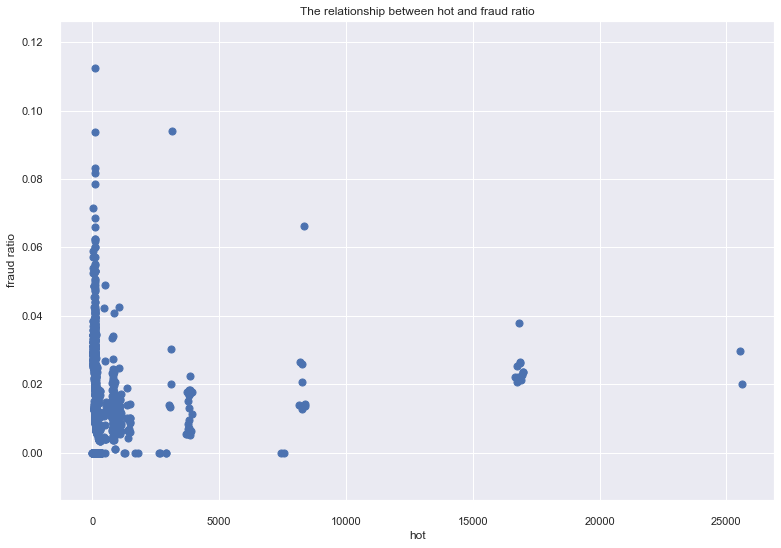

In [35]:
fig,axes = plt.subplots()
agg_merchant.plot(x='merchantHot',y='merchantFraud',kind='scatter',s=50,c='b',marker='o',ax=axes)

axes.set_title('The relationship between hot and fraud ratio')
axes.set_xlabel('hot')
axes.set_ylabel('fraud ratio')

We have noticed that the merchant frequency is negatively correalted with the fraud ratio, which means the more frequent a merchant is, the less possible it will associate with frauds.

It is also obvious that the distribution of 'merchantHot' is highly right skewed. Therefore we take the log and the data has been transformed in to a pretty good distribution.

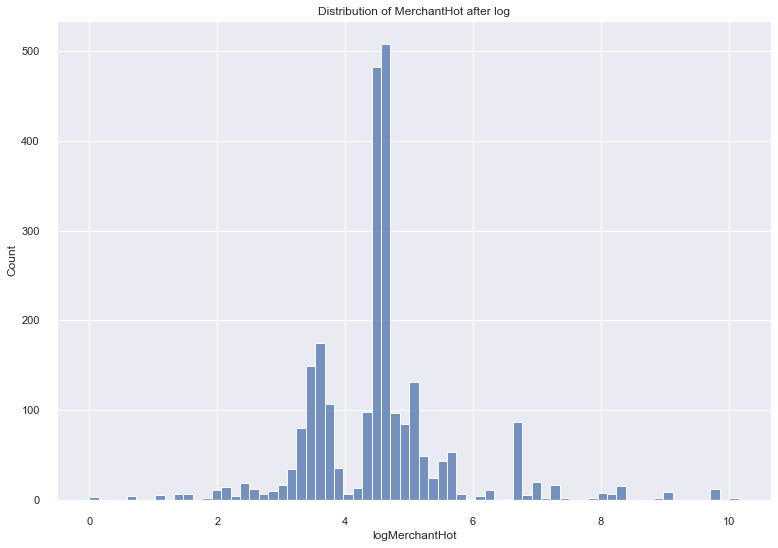

In [36]:
agg_merchant['logMerchantHot'] = agg_merchant['merchantHot'].apply(lambda x: np.log(x))
ax = sns.histplot(data = agg_merchant, x='logMerchantHot').set_title('Distribution of MerchantHot after log')

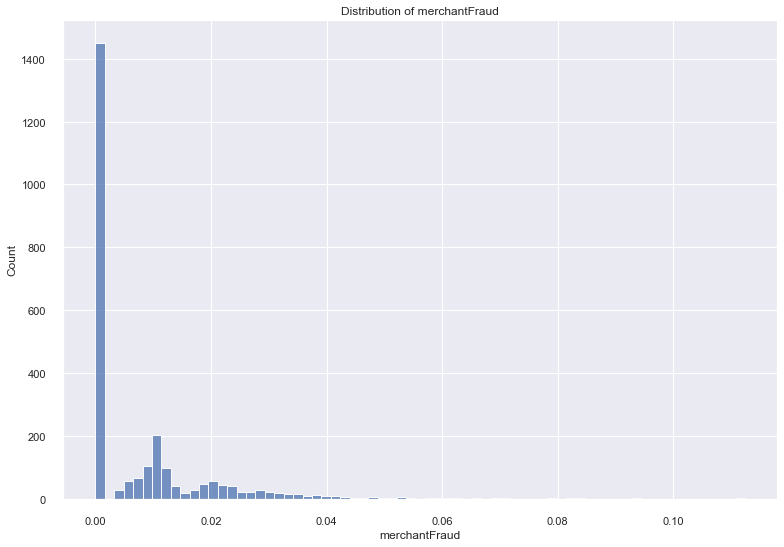

In [37]:
ax = sns.histplot(data = agg_merchant, x='merchantFraud').set_title('Distribution of merchantFraud')

#### Though the fraud percentage of a merchant has a good correlation with merchat hot, but we should not use this as feature. There is a strong data leakage with the feature since we actually use the 'isFraud' lable to construt it.

In [38]:
df = df.merge(agg_merchant[['merchantName', 'logMerchantHot']], on='merchantName', how='left')

#### Call the generate_wv_model function defined early and construct embedding features of merchants.

In [39]:
w2v2=[]
model2 = generate_wv_model(df, 'merchantName', 5)
for name in df.merchantName.unique():
    try:
        a = [name]
        a.extend(get_vector(model2, str(name), 5))
        w2v2.append(a)   #w2v save the accountNumber and vectors
    except:
        pass

In [40]:
vec_df2 = pd.DataFrame(w2v2)   #create a dataframe
vec_df2.columns = ['merchantName'] + ['merchant_vec'+str(i) for i in range(5)]
print(vec_df2.shape)

(2490, 6)


In [41]:
df = df.merge(vec_df2, on='merchantName', how='left')

In [42]:
print(df.shape)

(786363, 55)


### Number of transactions & transactionAmount
Output feature: 
- numTransaction: log number of transcations of the account
- avgAmount: total amount of transcations of the account


In [43]:
agg_trans = df[(df['isMultiple']==0)&(df['isReverse']==0)].groupby(["accountNumber"], as_index=False)['transactionAmount'].agg({"numTransaction":"count", "totalAmount": "sum"})
print(agg_trans.shape)

(5000, 3)


In [44]:
agg_trans['numTransaction'] = agg_trans['numTransaction'].apply(lambda x: np.log(x+1))
agg_trans['avgAmount'] = agg_trans.apply(lambda x: np.log(x['totalAmount']/x['numTransaction']+1), axis =1)

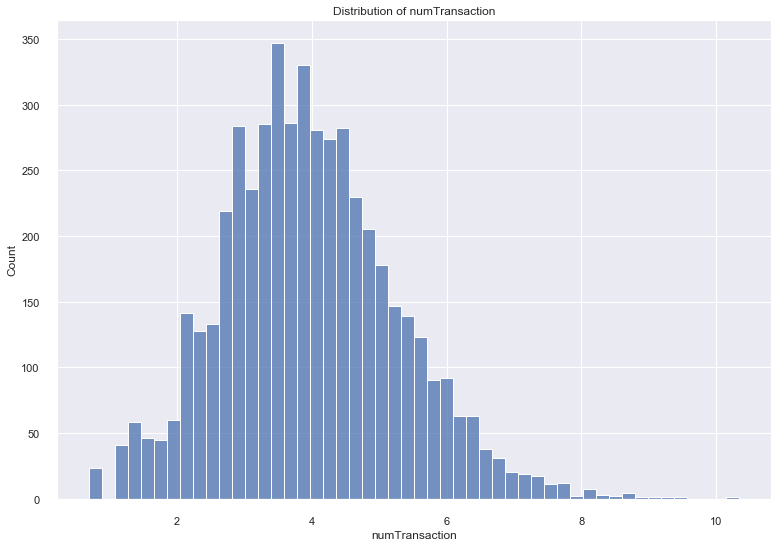

In [45]:
ax = sns.histplot(data = agg_trans, x='numTransaction').set_title('Distribution of numTransaction')

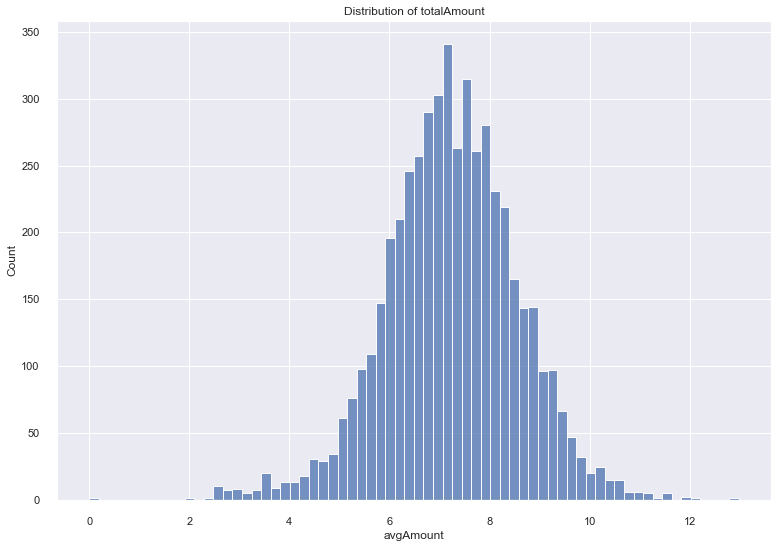

In [46]:
ax = sns.histplot(data = agg_trans, x='avgAmount').set_title('Distribution of totalAmount')

We can see great normal distributions after we adjust the data.

In [47]:
df = df.merge(agg_trans.drop(['totalAmount'], axis=1), on='accountNumber', how='left')

### Account Activity

Output feature: 
- active： This feature counts the number of transactions during the past 30 days.

Given those transaction data, we can design a statistical feature that captures the activity of an account during the past 30 days. This feature will introduce a colinearity with the previous feature. But it is acceptable for the models I will use. This part can be slow since it will go through every time window.

In [48]:
window_data = DataFrame(df[['transactionDateTimeStamp', 'accountNumber']].copy())
window_data = window_data.set_index(pd.DatetimeIndex(window_data['transactionDateTimeStamp']))

df_dict = {}
for account in window_data.accountNumber.unique():
    df_dict[account] = window_data[window_data['accountNumber'].isin([account])]

In [49]:
def f(x):
    data = df_dict[x['accountNumber']]
    t = x['transactionDateTimeStamp']
    delta_30 = timedelta(days=30, seconds=0, microseconds=0)
    num_slice = data.loc[(t - delta_30).strftime("%Y-%m-%d") : t.strftime("%Y-%m-%d")]
    return num_slice.shape[0]

df['active'] = df.apply(lambda x: f(x), axis = 1)

## Generate Smaples

In [50]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [51]:
continuous_cols = ['creditLimit', 'availableMoney', 'currentBalance', 'transactionAmount',
        'logMerchantHot', 'expDateDelta', 'openDateDelta', 'addressDateDelta','numTransaction', 'avgAmount','active']

time_cols = ['hour_cos', 'hour_sin', 'min_cos', 'min_sin']

categorical_cols =['posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'merchantCountryCode', 'transactionType', 'cardPresent',
     'matchingCVV', 'matchingCountry',
         'year', 'month', 'day',  'isReverse', 'isMultiple']

embbeding_cols = ['id_vec0', 'id_vec1', 'id_vec2', 'id_vec3', 'id_vec4', 'id_vec5',
       'id_vec6', 'id_vec7', 'id_vec8', 'id_vec9', 
       'merchant_vec0', 'merchant_vec1', 'merchant_vec2', 'merchant_vec3',
       'merchant_vec4']

using_cols = continuous_cols + categorical_cols + embbeding_cols + ['isFraud']

In [52]:
## https://my.oschina.net/kyo4321/blog/1823498

class One_hot_encoder:
    def __init__(self, df, column_name_list):
        self.df = df.astype(str)
        self.column_name_list = column_name_list
    
    def multi_column_encoder(self):
        Enc_ohe, Enc_label = OneHotEncoder(), LabelEncoder()
        for column_name in self.column_name_list:
            self.df["Dummies"] = Enc_label.fit_transform(self.df[column_name])
            self.df_dummies = pd.DataFrame(Enc_ohe.fit_transform(self.df[["Dummies"]]).todense(), columns = Enc_label.classes_)
            self.df_dummies.rename(columns=lambda x: column_name + "_" + x, inplace=True)
            self.df = pd.concat([self.df, self.df_dummies], axis=1) 
        self.df.drop(["Dummies"], axis=1, inplace=True)
        self.df.drop(self.column_name_list, axis=1, inplace=True) 
        return self.df

In [107]:
df_encoded = One_hot_encoder(df[using_cols], categorical_cols).multi_column_encoder()
print(df_encoded.shape)

(786363, 120)


### Outlier Detection

Now we would like to remove some outliers from the dataset. There are some ways to do so include quantile range or distance-based methods. However, those methods are tedious and can heavily rely on how we scale our data. Therefore, I choose the method of IsolationForest, which automatically select abnormal points without worring the scale.

In [113]:
from sklearn.ensemble import IsolationForest
using_df = df_encoded.copy()
scaler = StandardScaler()
np_scaled = scaler.fit_transform(using_df)
using_df = pd.DataFrame(np_scaled)
# Train a IsolationForest
model =  IsolationForest(contamination=0.05)
model.fit(using_df)

# 1 means normal，-1 means abnormal
df_encoded['anomaly2'] = pd.Series(model.predict(using_df))

### Standardization

Based on my experience and some demo classiferies I run before moving to this part, I would say Xgboost can always do a good job in similiar tasks. Another advantage of Xgboost is the scale-free property, which means we don't need to bother to tune the scale of our data input.

However, since I will still try different models in the next part, and proper standardization does improve the optimization performance, I will still apply the following standardization.

In [114]:
class Standardize():
    def __init__(self, df, column_name_list):
        self.df = df
        self.column_name_list = column_name_list
    
    def multi_column_standardize(self):
        ss = StandardScaler()
        for column_name in self.column_name_list:
            self.df[column_name] = ss.fit_transform(self.df[column_name].values.reshape(-1, 1))
        return self.df

In [115]:
df_standarized = Standardize(df_encoded, continuous_cols+embbeding_cols).multi_column_standardize()
print(df_standarized.shape)

(786363, 121)


Next, I would like to use a visualization technique to illustrate that the choice of outlier detection does work. The following method of t-SNE projects the high-dimension data into a 2-d vector. By plotting the 2-d data associating with anomaly2 label, we can clearly see there are some points in particular clusters that are abnormal, which indicates that our IsolationForest methods separates those outliers. 

Computing t-SNE embedding


Text(0.5, 1.0, 'Scatter Plot of t-SNE visualization')

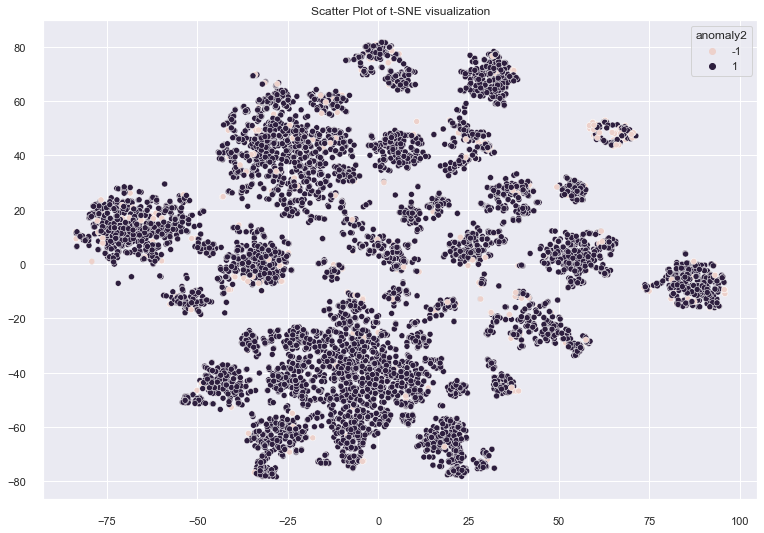

In [116]:
from sklearn.manifold import TSNE
# To speed-up the plot I subsample the data
df_sample = df_standarized.sample(frac=0.01, replace=False)
data, label = df_sample.drop(['anomaly2','isFraud'], axis=1), df_sample['anomaly2']
print('Computing t-SNE embedding')
tsne = TSNE(n_components=2, init='pca')
result = tsne.fit_transform(data)
sns.scatterplot(x=result.T[0], y=result.T[1], hue=label).set_title('Scatter Plot of t-SNE visualization')

In [117]:
df_standarized = df_standarized[df_standarized['anomaly2'] == 1].drop(['anomaly2'], axis=1)

In [118]:
for c in df_standarized.columns:
    print(c)

creditLimit
availableMoney
currentBalance
transactionAmount
logMerchantHot
expDateDelta
openDateDelta
addressDateDelta
numTransaction
avgAmount
active
id_vec0
id_vec1
id_vec2
id_vec3
id_vec4
id_vec5
id_vec6
id_vec7
id_vec8
id_vec9
merchant_vec0
merchant_vec1
merchant_vec2
merchant_vec3
merchant_vec4
isFraud
posEntryMode_02
posEntryMode_05
posEntryMode_09
posEntryMode_80
posEntryMode_90
posEntryMode_nan
posConditionCode_01
posConditionCode_08
posConditionCode_99
posConditionCode_nan
merchantCategoryCode_airline
merchantCategoryCode_auto
merchantCategoryCode_cable/phone
merchantCategoryCode_entertainment
merchantCategoryCode_fastfood
merchantCategoryCode_food
merchantCategoryCode_food_delivery
merchantCategoryCode_fuel
merchantCategoryCode_furniture
merchantCategoryCode_gym
merchantCategoryCode_health
merchantCategoryCode_hotels
merchantCategoryCode_mobileapps
merchantCategoryCode_online_gifts
merchantCategoryCode_online_retail
merchantCategoryCode_online_subscriptions
merchantCategoryCo

### Imbalanced Data & Sampling

In [119]:
df_standarized['isFraud'].value_counts()

0    736075
1     10969
Name: isFraud, dtype: int64

It is obvious that our current dataset is highly imbalanced, with much less fraud entries. This imbalance will lead to a terrible problem during classification. 

There are some methods including resampling and changing loss function. In particular, resampling can contain both over-sampling and under-sampling. I tried both methods and it turns out the over-sampling method ADASYN works better. It is natural since it lose less data. However, it makes my grid-search becoming slow due to the extra data.

In [120]:
X = df_standarized.drop(['isFraud'], axis=1).astype(float)
y = df_standarized['isFraud'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)

#### Please note it is important to split the train-test sets before doing the sampling. Spliting after sampling can produce a better score but it makes less sense in real tasks, since the natural data is imbalanced. My model should be evaluated as if it is running on real world data.

By spliting before sampling, the x_test and y_test keep the original imbalanced distribution.

After several tries, an imbalanced dataset can greatly lower the recall and further reduce the AUC. So a balanced dataset close to 1:1 is necessary.

In [121]:
ros = RandomUnderSampler()
X_train_under, y_train_under = ros.fit_resample(X_train, y_train)
print(f'Before Random Under Sampling: {X_train.shape}')
print(f'After Random Under Sampling: {X_train_under.shape}')

Before Random Under Sampling: (672339, 119)
After Random Under Sampling: (19694, 119)


In [126]:
from imblearn.over_sampling import SMOTE
new_X_train, new_y_train = SMOTE(sampling_strategy=1).fit_resample(X_train, y_train)
print(f'Before SMOTENC Over Sampling: {X_train.shape}')
print(f'After SMOTENC Over Sampling: {new_X_train.shape}')

Before SMOTENC Over Sampling: (672339, 119)
After SMOTENC Over Sampling: (1324984, 119)


In [123]:
# Check if the data balance now
print('Train data labeles:', new_y_train.value_counts(), '',sep='\n')
print('Test data labeles:', y_test.value_counts(), sep='\n')

Train data labeles:
0    662492
1    662492
Name: isFraud, dtype: int64

Test data labeles:
0    73583
1     1122
Name: isFraud, dtype: int64


## Data Export

In [127]:
data = {'x_train': new_X_train, 'x_test': X_test, 'y_train': new_y_train, 'y_test': y_test}
with open('Data/processed_data_over', 'wb') as file:
    pickle.dump(data, file, protocol=4)

In [128]:
data = {'x_train': X_train_under, 'x_test': X_test, 'y_train': y_train_under, 'y_test': y_test}
with open('Data/processed_data_under', 'wb') as file:
    pickle.dump(data, file, protocol=4)